In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import zipfile
import json
%matplotlib inline

In [2]:
df1 = pd.read_csv("./data-master/cdli_catalogue_1of2.csv",sep=",",encoding="utf-8",error_bad_lines=False)
df2 = pd.read_csv("./data-master/cdli_catalogue_2of2.csv",sep=",",encoding="utf-8",error_bad_lines=False,header=None,names=df1.columns)

cdli_df = df1.copy()
cdli_df = cdli_df.append(df2)

b'Skipping line 124239: expected 63 fields, saw 115\n'
C:\Users\320012960\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (9,23,24,25,28,29,52,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\320012960\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (3,4,9,22,23,25,32,37,52,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cdli_df_sum = cdli_df[cdli_df["language"]=="Sumerian"]
cdli_df_sum = cdli_df_sum[~cdli_df_sum["period"].isna()]
cdli_df_sum = cdli_df_sum[cdli_df_sum["period"].str.contains("Ur III")]
len(cdli_df_sum["id_text"].unique())

104528

In [4]:
with zipfile.ZipFile('./epsd2-admin-u3adm.zip') as myzip:
    corpusnames = [x for x in myzip.namelist() if ("corpusjson" in x) and ("/P") in x]
    
corpus_ids = [int(re.findall(r'\/P(.*).json',x)[0]) for x in corpusnames]
corpus_df = pd.DataFrame(data={"ID":corpus_ids})

dict_id2cdliyear = cdli_df_sum[["id_text","date_of_origin"]].set_index("id_text")["date_of_origin"].to_dict()
corpus_df["DATE"] = corpus_df["ID"].map(dict_id2cdliyear)
corpus_df = corpus_df.dropna()

corpus_df["DATE_CHECK"] = corpus_df["DATE"].apply(lambda x: np.any([y in x for y in ['Shulgi','Ibbi-Suen','Shu-Suen','Amar-Suen']]))
corpus_df=corpus_df[corpus_df["DATE_CHECK"]]

def split_date(the_date):
    the_year,the_month,the_day,comments = np.nan,np.nan,np.nan,np.nan
    splitted_date = the_date.split(".")
    the_year = ".".join(splitted_date[:2])
    if len(splitted_date)>2:
        the_month = splitted_date[2]
    if len(splitted_date)>3:
        splitted_day = splitted_date[3].split(" ")
        the_day = splitted_day[0]
        if len(splitted_day)>1:
            comments = "".join(splitted_day[1:])
    return the_year,the_month,the_day,comments

corpus_df["YEAR"] = corpus_df["DATE"].apply(lambda x: split_date(x)[0])
corpus_df["MONTH"]= corpus_df["DATE"].apply(lambda x: split_date(x)[1])
corpus_df["DAY"]= corpus_df["DATE"].apply(lambda x: split_date(x)[2])
corpus_df["DATE_COMMENTS"]= corpus_df["DATE"].apply(lambda x: split_date(x)[3])

data_y_df = pd.read_csv("./src1/year_data.csv",sep=";")
data_y_df["K"] = data_y_df["K"].map({'Shulgi':'Shulgi',
                                          'Unknown':'Unknown',
                                          'Ibb-Sin':'Ibbi-Suen',
                                          'Szu-Sin':'Shu-Suen',
                                          'Amar-Sin':'Amar-Suen',
                                          'Ur-Nammu':'Ur-Namma'})
data_y_df["K.Y_NUM"] = data_y_df["K"]+"."+data_y_df["Y_NUM"].apply(lambda x:"{:02d}".format(x))
dict_cdliyear2ybc = data_y_df[["K.Y_NUM","Y_BC"]].set_index("K.Y_NUM")["Y_BC"].to_dict()
dict_ybc2cdliyear = dict([(v,k) for k,v in dict_cdliyear2ybc.items()])

corpus_df["YEAR_BC"] = corpus_df["YEAR"].map(dict_cdliyear2ybc)
corpus_df = corpus_df[~pd.isna(corpus_df["YEAR_BC"])].drop("DATE_CHECK",axis=1)

In [49]:
def get_tablet_rawjson(tablet_id):
    fname="epsd2/admin/u3adm/corpusjson/P{}.json".format(tablet_id)
    with zipfile.ZipFile('./epsd2-admin-u3adm.zip') as myzip:
        with myzip.open(fname,"r") as f:
            text=f.read()
            json_data = json.loads(text)
    return json_data

def parse_tablet_json(data):
    for x in data["cdl"]:
        node_value = x.get("node")
        if node_value=="c":
            for chunk in parse_tablet_json(x):
                yield chunk
        else:
            if node_value=="d":
                '''
                if x.get("type")=="line-start":
                    yield ("D","\n$:","\n$:")
                else:
                    yield ("D","\n$"+x.get("type"),"\n$"+x.get("type"))
                '''    
                if x.get("type")=="line-start":
                    yield ("D","\n","\n")
                else:
                    yield ("D","\n@"+x.get("type"),"\n@"+x.get("type"))
            elif node_value=="l":
                text_fragment = x.get("frag")
                text_lem = x.get("inst")
                for symbol in [u"⸢",u"⸣","[","]","<",">"]:
                    text_fragment = text_fragment.replace(symbol,"")
                    
                ## The following line replaces '4(aš@c)' by '4(aš)'
                ## It is used to simplify the further treatment of quantities
                text_fragment = re.sub(r'([0-9]\(.*)@.',r'\1',text_fragment)
                yield ("L",text_fragment,text_lem)
                
def parse_corpus(id_list):
    with zipfile.ZipFile('./epsd2-admin-u3adm.zip') as myzip:
        data_dict = {}
        for tablet_id in id_list:    
            try:
                fname="epsd2/admin/u3adm/corpusjson/P{}.json".format(tablet_id)
                with myzip.open(fname,"r") as f:
                    text=f.read()
                    json_data = json.loads(text)
                parsed_data = list(parse_tablet_json(json_data))
                data_dict[tablet_id]={"raw":" ".join([x[1] for x in parsed_data]),
                                      "splitted":[(x[1],x[2]) for x in parsed_data if x[0]=="L"],
                                      "splitted_withsep":[(x[1],x[2]) for x in parsed_data]}
                
                data_dict[tablet_id]["raw"] = data_dict[tablet_id]["raw"]
            except:
                print("Error on id: ",tablet_id)
                data_dict[tablet_id]={"raw":"",
                                      "splitted":[]}
    return data_dict

In [50]:
import time

t0=time.time()
data_dict = parse_corpus(list(corpus_df["ID"].values))
print("Corpus parsed in ",time.time()-t0)

Error on id:  124601
Corpus parsed in  50.51318717002869


In [51]:
corpus_df["GIRI3"] = corpus_df["ID"].apply(lambda x: len(re.findall(r'giri₃ ',data_dict[x]["raw"],re.MULTILINE)))
corpus_df["SUBATI"] = corpus_df["ID"].apply(lambda x: len(re.findall(r'šu#?(?:-|\ )ba#?(?:-|-an#?-)ti#?(?:-a|-eš)?',data_dict[x]["raw"],re.MULTILINE)))
corpus_df["KI"] = corpus_df["ID"].apply(lambda x:  len([x[1] for x in data_dict[x]["splitted"] if "ki[place]"==x[1]]))
corpus_df["I3-DAB5"] = corpus_df["ID"].apply(lambda x: len(re.findall(r'i₃-dab₅',data_dict[x]["raw"],re.MULTILINE)))

Total: 53338
GIRI3 >0: 9183
KI >0: 31394
SUBATI >0: 12155
I3-DAB5 >0: 7323
Known years: 53338


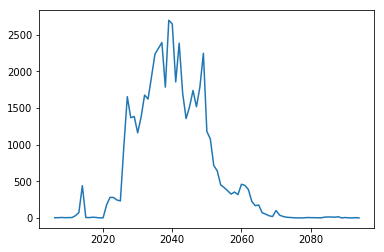

In [52]:
print("Total:",len(corpus_df))
print("GIRI3 >0:",len(corpus_df[corpus_df["GIRI3"]>0]))
print("KI >0:",len(corpus_df[corpus_df["KI"]>0]))
print("SUBATI >0:",len(corpus_df[corpus_df["SUBATI"]>0]))
print("I3-DAB5 >0:",len(corpus_df[corpus_df["I3-DAB5"]>0]))

the_filter = (corpus_df["YEAR_BC"]>-1)
print("Known years:",len(corpus_df[the_filter]))
corpus_df[the_filter]["YEAR_BC"].value_counts().sort_index().plot()

14449


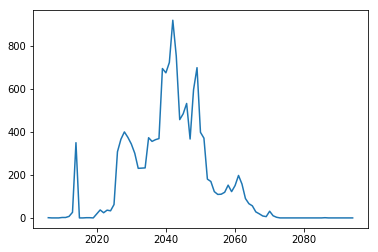

In [53]:
the_filter = (corpus_df["SUBATI"]==1) & (corpus_df["KI"]==1)
the_filter |= (corpus_df["I3-DAB5"]==1) & (corpus_df["KI"]==1)
the_filter &= (corpus_df["YEAR_BC"]>-1)
print(len(corpus_df[the_filter]))
transac_df = corpus_df[the_filter].copy()
transac_df["YEAR_BC"].value_counts().sort_index().plot()

In [54]:
def get_giri3_information(splitted_text):
    info=""
    for i,elem in enumerate(splitted_text):
        if elem[1]=="ŋiri[foot]":
            try:
                if (splitted_text[i+1][1] in ["PN","X"]):
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
            except:
                pass
    return info

def get_subati_information(splitted_text):
    info=""
    for i,elem in enumerate(splitted_text):
        if len(re.findall(r'ba#?(?:-|-an#?-)ti#?',elem[0])) and len(re.findall(r'šu#?',splitted_text[i-1][0])):
            if (splitted_text[i-3][1]=="dumu[child]" and splitted_text[i-4][1] in ["PN","X"]):
                info = splitted_text[i-4][0]
            elif (splitted_text[i-2][1] in ["PN","X"]):
                info = splitted_text[i-2][0]
            elif (splitted_text[i-2][1] in ['šabra[administrator]',"damgar[merchant]","išib[priest]",
                                            'nagar[carpenter]','sukkal[secretary]','kuš[official]','engar[farmer]',
                                            'ensik[ruler]','dubsar[scribe]','uddatuš[jester]','malah[sailor]',
                                            'ugula[overseer]','muhaldim[cook]','nubanda[overseer]','kurušda[fattener]',
                                            'unud[cowherd]','ašgab[leatherworker]','gala[singer]',
                                            'šuʾi[barber]','ummia[expert]','munumud[maltster]',
                                            'nagada[herdsman]','bahar[potter]','tugdu[felter]','sipad[shepherd]','šakkanak[general]','šukud[fisherman]',
                                            'ragaba[rider]','kaguruk[supervisor]','guzala[official]','saŋŋa[official]','nukirik[gardener]'
                                           ] and splitted_text[i-3][1] in ["PN","X"]):
                info = splitted_text[i-3][0]
            elif (splitted_text[i-3][1] in ['ensik[ruler]','šabra[administrator]','saŋŋa[official]',
                                            'sipad[shepherd]','ugula[overseer]','nubanda[overseer]'] and splitted_text[i-4][1] in ["PN","X"]):
                info = splitted_text[i-4][0]
            elif splitted_text[i-2][0] in ["ur-tur","dingir-ra-ke₄",
                                           "du₁₁-ga","lu₂-kal-la","bi₂-du₁₁-ga",
                                           "ARAD₂-dam","kas₄","sukkal-mah","la-a",
                                           "i₃-du₈","na-ba-sa₂",
                                           'ma-an-šum₂','ki-ag₂',
                                           'ARAD₂',
                                           'me-me','gi₄-zabalaₓ(|UNUG.MUŠ₃.ZA|){ki}ke₄','ud-du-ur','ab-ba','nin-a-na','šeš-a-ni','ka-tar-ni',
                                           'lugal-ur₂-ra-ni','nig₂-gur₁₁','ad-da','nam-mah','ku₅-da-a','a-tu','ku-li'
                                          ]:
                info=splitted_text[i-2][0]
    return info

def get_i3dab5_information(splitted_text):
    info=""
    for i,elem in enumerate(splitted_text):
        if elem[1]=="dab[seize]":
            if (splitted_text[i-2][1]=="dumu[child]" and splitted_text[i-3][1] in ["PN","X"]):
                info = splitted_text[i-3][0]
            elif (splitted_text[i-1][1] in ["PN","X"]):
                info = splitted_text[i-1][0]
            elif (splitted_text[i-1][1] in ['šabra[administrator]',"damgar[merchant]","išib[priest]",
                                            'nagar[carpenter]','sukkal[secretary]','kuš[official]','engar[farmer]',
                                            'ensik[ruler]','dubsar[scribe]','uddatuš[jester]','malah[sailor]',
                                            'ugula[overseer]','muhaldim[cook]','nubanda[overseer]','kurušda[fattener]',
                                            'unud[cowherd]','ašgab[leatherworker]','gala[singer]',
                                            'šuʾi[barber]','ummia[expert]','munumud[maltster]',
                                            'nagada[herdsman]','bahar[potter]','tugdu[felter]','sipad[shepherd]','šakkanak[general]','šukud[fisherman]',
                                            'ragaba[rider]','kaguruk[supervisor]','guzala[official]','saŋŋa[official]','nukirik[gardener]'
                                           ] and splitted_text[i-2][1] in ["PN","X"]):
                info = splitted_text[i-2][0]
            elif (splitted_text[i-2][1] in ['ensik[ruler]','šabra[administrator]','saŋŋa[official]',
                                            'sipad[shepherd]','ugula[overseer]','nubanda[overseer]'] and splitted_text[i-3][1] in ["PN","X"]):
                info = splitted_text[i-3][0]
            elif splitted_text[i-1][0] in ["ur-tur","dingir-ra-ke₄",
                                           "du₁₁-ga","lu₂-kal-la","bi₂-du₁₁-ga",
                                           "ARAD₂-dam","kas₄","sukkal-mah","la-a",
                                           "i₃-du₈","na-ba-sa₂",
                                           'ARAD₂',
                                           'ma-an-šum₂','ki-ag₂',
                                           'me-me','gi₄-zabalaₓ(|UNUG.MUŠ₃.ZA|){ki}ke₄','ud-du-ur','ab-ba','nin-a-na','šeš-a-ni','ka-tar-ni',
                                           'lugal-ur₂-ra-ni','nig₂-gur₁₁','ad-da','nam-mah','ku₅-da-a','a-tu','ku-li'
                                          ]:
                info=splitted_text[i-1][0]
    return info

def get_ki_information_regex(text):
    info = re.findall(r'ki\s((?:.|\n)*)-ta',text)
    if len(info):
        return info[0]
    else:
        return ""

def get_ki_information(splitted_text):
    info=""
    for i,elem in enumerate(splitted_text):
        if elem[1]=="ki[place]":
            try:
                if (splitted_text[i+1][1] in ["PN","X"]) and not ("ba-zi" in splitted_text[i+1][0]):
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("ba-zi" in splitted_text[i+1][0]):
                    ## 'ba-zi' is a PN
                    info = "ba-zi"
                        
                if ("ensi₂" in splitted_text[i+1][0]):
                    ## 'ensi₂' indicates a ruler
                    if ("-ta" in splitted_text[i+1][0]): ## if "ensi₂-(XX)-ta" nothing else follows, so the determination is complete
                        info = "ensi₂"
                    else: ## In the other case, a GN follows (as in 'ruler of ...') so we add it
                        info = "ensi₂ "+re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+2][0])
                        
                if ("sanga" in splitted_text[i+1][0]):
                    ## 'sanga' indicates the administrator of a temple, and is followed by the name of the deity
                    info = "sanga "+re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+2][0])
                    
                if ("u"==splitted_text[i+1][1]):
                    ## 'u' indicates unknown, usually badly corrupted, but we'll also take it
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                if ("šeš" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'šeš-a-ni-ta' so we'll consider it as a PN
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("kaš" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'kaš-ta' so we'll consider it as a PN
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("sag[good]" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'ba-sa₆-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("DN" in splitted_text[i+1][1]):
                    ## DN = Deity names
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                ### TODO: šabra[administrator]
                    
                if ("nammah" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'nam-mah-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("lu[person]" in splitted_text[i+1][1]):
                    if ("-ta" in splitted_text[i+1][0]): ## if "lu₂-(XX)-ta" nothing else follows, so the determination is complete
                        info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    else: 
                        info = "lu₂ "+re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+2][0])
                        
                if ("diŋir[deity]" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'dingir-ra-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("kaguruk[supervisor]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'ka-guru₇-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("mada[land]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'ma-ni-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("damgar[merchant]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'dam-gar₃-ne-ta' or variants, so we'll consider it 
                    ### TODO: is this a PN, or a function ?
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("lukala[official]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'lu₂-kal-la' or variants, so we'll consider it
                    ### It's a PN: look at tablet P143404, where the lemmatization indicates 'lu₂-kal-la' as a PN
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("ugula[overseer]" in splitted_text[i+1][1]):    
                    ## This is a function name, we will parse all following words until we find "-ta" in it
                    c=2
                    info = refsplitted_textined[i+1][0]+" "
                    while(not "-ta" in splitted_text[i+c][0]):
                        info = splitted_text[i+c][0]+" "
                        c=c+1
                    info = info+" "+re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+c][0])
                    
                if ("niŋurum[property]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'nig₂-u₂-rum' or variants, so we'll consider it
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                ### TODO: nukirik[gardener]
                    
                if ("na[man]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this seems to corresponds to PN
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("unud[cowherd]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'unu₃-e-ne' or variants, so we'll consider it
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("udul[herdsman]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'u₂-du-lu' or variants, so we'll consider it
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
            except:
                pass
            
    return info

In [55]:
transac_df["GIRI3_NAME"] = transac_df["ID"].apply(lambda x: get_giri3_information(data_dict[x]["splitted"]))
transac_df["SUBATI_NAME"] = transac_df["ID"].apply(lambda x: get_subati_information(data_dict[x]["splitted"]))
transac_df["KI_NAME"] = transac_df["ID"].apply(lambda x: get_ki_information(data_dict[x]["splitted"]))
#transac_df["KI_NAME"] = transac_df["ID"].apply(lambda x: get_ki_information_regex(data_dict[x]["raw"]))
transac_df["I3-DAB5_NAME"] = transac_df["ID"].apply(lambda x: get_i3dab5_information(data_dict[x]["splitted"]))
transac_df.head()

,ID,DATE,YEAR,MONTH,DAY,DATE_COMMENTS,YEAR_BC,GIRI3,SUBATI,KI,I3-DAB5,GIRI3_NAME,SUBATI_NAME,KI_NAME,I3-DAB5_NAME
2,121532,Ibbi-Suen.02.06.00 (Reichskalender),Ibbi-Suen.02,06,00,(Reichskalender),2027.0,0,1,1,0,,kur-ša-num₂,er₃-re-eb,
8,405489,Amar-Suen.05.11.00,Amar-Suen.05,11,00,NaN,2042.0,0,1,1,0,,{d}šul-gi-iri-mu,{d}šul-gi-a-a-mu,
14,132960,Amar-Suen.07.00.00,Amar-Suen.07,00,00,NaN,2040.0,0,1,1,0,,ur-sa₆-ga-mu,ur-nigar{gar}ta,
17,124307,Amar-Suen.09.12d.10 (intercalated),Amar-Suen.09,12d,10,(intercalated),2038.0,0,0,1,1,,,zu-ba-ga,a-a-kal-la
26,128809,Amar-Suen.02.04.11,Amar-Suen.02,04,11,NaN,2045.0,0,0,1,1,,,ab-ba-sa₆-ga,na-lu₅


In [56]:
data_dict[124307]["raw"]

'\n@tablet \n@obverse \n@nonx \n 1(diš) sila₄ ga \n u₄ 1(u)-kam \n KA-NE-še₃ \n a-a-kal-la i₃-dab₅ \n@reverse \n ki zu-ba-ga-ta \n ba-zi \n@nonx \n iti diri še-sag₁₁-ku₅ \n mu en {d}nanna kar-zi-da ba-hun \n@seal \n@column \n {d}šu-{d}suen \n nita kal-ga \n lugal uri₅{ki}ma \n@column \n ARAD₂-{d}nanna \n dumu a-a-kal-la \n muhaldim-gal lugal'

In [57]:
from mayonnaise import Matcher

ur3nam_df = pd.read_csv("./ur3nam.csv",sep="\t")
## Convert to lower case to avoid problems
ur3nam_df["Transliteration"] = ur3nam_df["Transliteration"].str.lower()

## Trains a string matcher to find the closest transliteration
name_matcher = Matcher(ngram_length=4)
name_matcher.fit(ur3nam_df["Transliteration"].values)

## This dictionary serves to map transliterations to normalized names
dict_names_translit2normal = dict(ur3nam_df[["Transliteration","Normalized"]].values)
for k,v in dict_names_translit2normal.items():
    dict_names_translit2normal[k] = v.split("[]")

## The transliterations use ASCII so we need a helper function if we deal with UTF-8
def sux_utf8_2_ascii(raw):
    raw = raw.replace("š","c") ## For the purpose of name matching, 'š' has to be replaced by 'c'
    for i,subscript in enumerate([u"\u2080",u"\u2081",u"\u2082",u"\u2083",
                                  u"\u2084",u"\u2085",u"\u2086",u"\u2087",
                                  u"\u2088",u"\u2089"]):
        raw = raw.replace(subscript,str(i))
    return raw.lower()

## Normalizing names is a two-step process: for a given string, we need first to
## find the best match in the existing transliterations, then we need to find
## the corresponding normalized names.
## To avoid repetitive and lengthy computations on single strings, we take advantage
## of fast vectorization operations and compute a dictionary of string matchings.
## (dictionaries are O(1) and thus very fast)
## Then we will apply the dict_names_translit2normal dictionary to find the normalized
## name.

def normalizing_dict(names):
    ## Since the transliterations are given in ascii, we will convert it
    mapper_dict = name_matcher.get_matcher_dict([sux_utf8_2_ascii(x) for x in names if not x==""])

    normalizing_dict={}
    for x in names:
        y=sux_utf8_2_ascii(x)
        if mapper_dict.get(y):
            ## The mapper_dict gives the closest transliteration + score...
            match,score = mapper_dict.get(y)
            ## Then we find the normalized name
            normalizing_dict[x] = (*dict_names_translit2normal[match],score)
    ## We need to take care of the empty string
    normalizing_dict[""]=("","",0.0)
    
    return normalizing_dict

In [58]:
ki_name_mapper = normalizing_dict(transac_df["KI_NAME"].unique())
subati_name_mapper = normalizing_dict(transac_df["SUBATI_NAME"].unique())
i3dab5_name_mapper = normalizing_dict(transac_df["I3-DAB5_NAME"].unique())

transac_df[["KI_NORMALIZED",
            "KI_NORMALIZED_TYPE",
            "KI_NORMALIZED_SCORE"]] = transac_df["KI_NAME"].apply(lambda x: pd.Series(ki_name_mapper[x]))

transac_df[["SUBATI_NORMALIZED",
            "SUBATI_NORMALIZED_TYPE",
            "SUBATI_NORMALIZED_SCORE"]] = transac_df["SUBATI_NAME"].apply(lambda x: pd.Series(subati_name_mapper[x]))

transac_df[["I3-DAB5_NORMALIZED",
            "I3-DAB5_NORMALIZED_TYPE",
            "I3-DAB5_NORMALIZED_SCORE"]] = transac_df["I3-DAB5_NAME"].apply(lambda x: pd.Series(i3dab5_name_mapper[x]))


In [59]:
def get_receiver(x):
    if len(x["SUBATI_NORMALIZED"]):
        return x["SUBATI_NORMALIZED"]
    if len(x["I3-DAB5_NORMALIZED"]):
        return x["I3-DAB5_NORMALIZED"]
    return ""
transac_df["RECEIVER"] = transac_df.apply(get_receiver,axis=1)
transac_df["SENDER"] = transac_df["KI_NORMALIZED"]

### SAVING FOR THE FORCE-LAYOUT VISUALIZATION

In [60]:
transac_df_filtered = transac_df.copy()
the_filter = transac_df_filtered["RECEIVER"].str.len()>0
the_filter &= transac_df_filtered["SENDER"].str.len()>0
the_filter &= ~(transac_df_filtered["SENDER"]==transac_df_filtered["RECEIVER"])
transac_df_filtered = transac_df_filtered[the_filter]

## EXPORT FOR THE D3 VISUALIZATION

json_data = {}
json_data["links"] = []
for i in range(len(transac_df_filtered)):
    source = transac_df_filtered.iloc[i]["SENDER"]
    target = transac_df_filtered.iloc[i]["RECEIVER"]
    cdli_id = transac_df_filtered.iloc[i]["ID"]
    raw = data_dict[cdli_id]["raw"]
    year = transac_df_filtered.iloc[i]["YEAR_BC"]
    json_data["links"].append({"source":source,"target":target,"value":1,"raw":raw,"cdli":int(cdli_id),"year":int(year)})
            
json_data["Y_2_SUMY"] = dict_ybc2cdliyear

import json
with open('./force_layout.json', 'w') as outfile:
    json.dump(json_data, outfile)

### MERCHANDISE ANALYSIS

In [17]:
def unit_converter(the_list,units):
    count=0
    for x in the_list:
        for y in x:
            if not y[0]=="n":
                the_int=eval(y.split("(")[0]) ## Will take care of fractions
                for unit_name,unit_factor in units:
                    if unit_name in y:
                        count+=unit_factor*the_int
                        break
    return count

num_converter = lambda x: unit_converter(x,[("(diš)",1),("(u)",10),("(geš₂)",60),("(gešʾu)",600)])
capacity_converter = lambda x: unit_converter(x,[("(diš)",1),("(ban₂)",10),("(barig)",60),("(aš)",300),
                                                 ("(u)",3000),("(geš₂)",18000),("(gešʾu)",180000),
                                                 ("(šar₂)",1080000),("(šarʾu)",10800000)])

def merch_backtracking(tablet_idx,merch_tokens,converter):
    splitted_data = data_dict[tablet_idx]["splitted_withsep"]
    d=[]
    for i in range(len(splitted_data)):
        flag=1
        for j,merch_token in enumerate(merch_tokens):
            try:
                flag = flag & (splitted_data[i+j][0]==merch_token)
            except:
                flag=0
        if flag:
            seq = []
            flag=0
            c=i-1
            while(not flag):
                if splitted_data[c][1]=='n':
                    seq.append(splitted_data[c][0])
                else:
                    flag=1
                c-=1
            d.append(seq)
    return converter(d)

In [19]:
transac_df_goods = transac_df.copy()
transac_df_goods=transac_df_goods[(transac_df_goods["RECEIVER"].str.len()>0) & (transac_df_goods["SENDER"].str.len()>0)]

transac_df_goods["SILA4"] = transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["sila₄"],num_converter))
transac_df_goods["GU4"] = transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["gu₄"],num_converter))
transac_df_goods["UDU"] = transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["udu"],num_converter))
transac_df_goods["MAS2"] = transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["maš₂"],num_converter))
transac_df_goods["UD5"] = transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["ud₅"],num_converter))
transac_df_goods["AB2"] = transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["ab₂"],num_converter))
transac_df_goods["KU6"] = transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["ku₆"],num_converter))

transac_df_goods["SZE"] = transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["še"],capacity_converter))
transac_df_goods["SZE"] += transac_df_goods["ID"].apply(lambda x: merch_backtracking(x,["sila₃","še"],capacity_converter))

In [570]:
## EXPORT FOR THE D3 VISUALIZATION

json_data = {}
json_data["qties"] = []
for i in range(len(transac_df_sila)):
    data={}
    for column_name in ["SENDER","RECEIVER","YEAR_BC",
                        "SILA4","GU4","MAS2","UD5","UDU","AB2","KU6",
                        "SZE"]:
        value = transac_df_goods.iloc[i][column_name]
        if not type(value)==str:
            data[column_name]=int(value)
        else:
            data[column_name]=value
    json_data["qties"].append(data)
json_data["YEAR_DATA"] = dict_ybc2cdliyear           

import json
with open('./all_merch.json', 'w') as outfile:
    json.dump(json_data, outfile)